In [1]:
TRAIN = '/kaggle/input/barcode-and-qr-code-image-dataset/Dataset/'

We want image embeddings for both EDA and classification, so let's add some code that will get us image embeddings from ResNeXt.

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 143MB/s]


Next let's get our image embeddings and thumbnails. We don't have a lot of data, so let's load it all.

In [3]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'])
        for index, input_file in enumerate(list(iglob(pathname=arg))) if input_file.endswith('.jpg')]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*')}
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
print('done in {}'.format(arrow.now() - time_start))

encoded 13 rows of BarCode-QRCode  in 0:00:02.833175
encoded 242 rows of BarCode  in 0:00:52.825817
encoded 275 rows of QRCode  in 0:00:48.770183
done in 0:01:44.483439


We know our classes are unbalanced. How unbalanced are they?

In [4]:
train_df['tag'].value_counts(normalize=True).to_frame().T

tag           QRCode   BarCode  BarCode-QRCode
proportion  0.518868  0.456604        0.024528

We may be able to tell QR codes from barcodes, but there's probably no way we can balance our dataset. Let's proceed and find out what we can do.

First let's use TSNE to get x/y coordinates for our images.

In [5]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 530 samples in 0.003s...
[t-SNE] Computed neighbors for 530 samples in 0.112s...
[t-SNE] Computed conditional probabilities for sample 530 / 530
[t-SNE] Mean sigma: 4.839781
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.404846
[t-SNE] KL divergence after 1000 iterations: 0.416786


Now we're ready to plot.

In [6]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']])
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: Pokemon', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=8, color=mapper)
show(plot_figure)

Loading BokehJS ...

What a pleasant surprise. TSNE easily clusters QR codes together and bar codes together, for the most part. And the hybrid class is poorly represented, but its instances cluster together too. Let's build and model and see how it does.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['value'].apply(pd.Series), train_df['tag'], test_size=0.2, random_state=2024, stratify=train_df['tag'])
logreg = LogisticRegression(max_iter=10000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test)))

model fit in 137 iterations
accuracy: 0.9906
f1: 0.9897
                precision    recall  f1-score   support

       BarCode       0.98      1.00      0.99        48
BarCode-QRCode       1.00      0.67      0.80         3
        QRCode       1.00      1.00      1.00        55

      accuracy                           0.99       106
     macro avg       0.99      0.89      0.93       106
  weighted avg       0.99      0.99      0.99       106



Wow. This is probably better than we would have hoped for, especially for the hybrid class.

<Axes: >

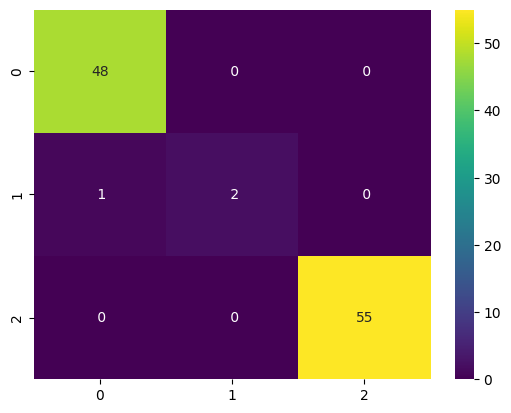

In [8]:
from seaborn import heatmap
from sklearn.metrics import confusion_matrix

heatmap(annot=True, data=pd.DataFrame(data=confusion_matrix(y_true=y_test, y_pred=logreg.predict(X=X_test), ),), cmap='viridis', fmt='2')

We have exactly one misclassification, and unsurprisingly it is in the hybrid class.

Let's take a look at our model probabilities. When our f1 is so high we expect them to be pretty high.

<Axes: xlabel='x', ylabel='y'>

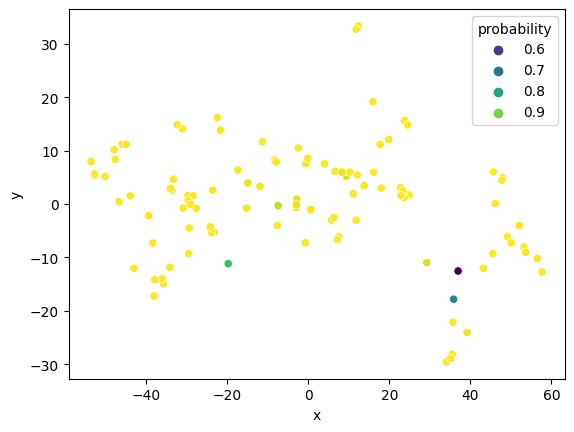

In [9]:
from seaborn import scatterplot

plot_df = train_df.iloc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)
scatterplot(data=plot_df, x='x', y='y', hue='probability', palette='viridis')

Not surprisingly our low model probabilities are concentrated near our hard cases.